In [1]:
# see more styles and js code (linked at the bottom) at https://www.tylerxhobbs.com/words/flow-fields

In [2]:
from vfield import render_flow_field
import torch
import matplotlib.pyplot as plt
from PIL import Image

vfield = torch.load('../data/vectorfield.pt')

grid = vfield['grid']
displacement=vfield['displacement']

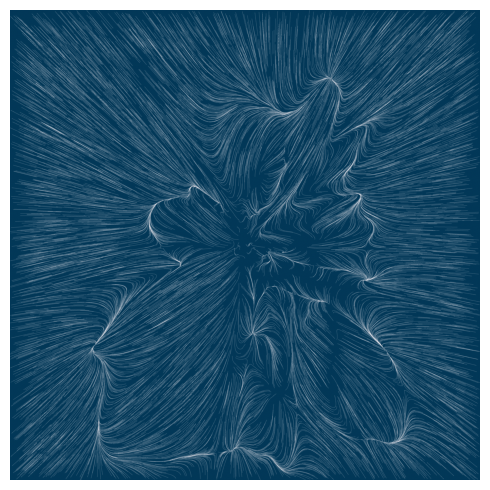

In [4]:
ff_img = render_flow_field(grid, displacement, 
                           W=5600, H=5600, 
                           steps=500, 
                           step_size=0.0001,
                           particles=10_000,
                           bg_color=255)

plt.figure(figsize=(10, 5))
plt.imshow(ff_img, cmap='PuBu', origin='lower')
plt.axis('off')
plt.tight_layout()
plt.show()

ff_img = ff_img.transpose(Image.FLIP_TOP_BOTTOM)
ff_img.save('../flow-field.png')
ff_img.show()